2.9.1
2.9.0
(1200, 28, 28)
(1200, 28, 28, 1)


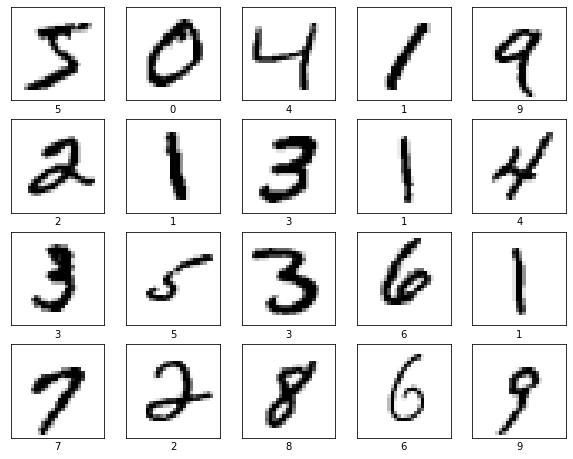

In [1]:
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dropout, Flatten

#from keras.callbacks import LearningRateScheduler

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV
#from keras.constraints import maxnorm

print(tf.__version__)
print(keras.__version__)

# fix random seed for reproducibility
np.random.seed(42)

mnist = keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])


# normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

#Take a subset of train for grid search. Let us take 5% for now
from sklearn.model_selection import train_test_split
x_grid, x_not_use, y_grid, y_not_use = train_test_split(x_train, y_train, test_size=0.98, random_state=42)
print(x_grid.shape)

x_grid = np.expand_dims(x_grid, axis=3)

print(x_grid.shape)

In [2]:
#USe convolutional layers as feature extractors. 
#NOTE: Not using transfer learning for this example but it is recommended to 
# import VGG16 or other pre-trained networks for real world problems. 
SIZE = x_grid.shape[1]
def feature_extractor():       
    activation = 'sigmoid'
    feature = Sequential()
    
    feature.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (SIZE, SIZE, 1)))
    feature.add(BatchNormalization())
    
    feature.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
    feature.add(BatchNormalization())
    feature.add(MaxPooling2D())
    
    feature.add(Flatten())
    
    return feature


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                        

<AxesSubplot:>

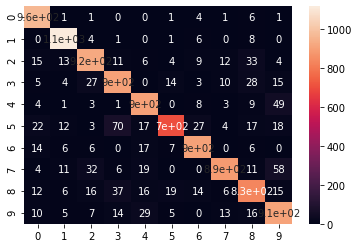

In [3]:
#Now, let us use features from convolutional network for RF
feature_extractor = feature_extractor()
print(feature_extractor.summary())

X_for_RF = feature_extractor.predict(x_grid) #This is our X input to RF and other models

#RANDOM FOREST ONLY
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
RF_model.fit(X_for_RF, y_grid) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = feature_extractor.predict(np.expand_dims(x_test, axis=3))

#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_feature)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_RF))

#Confusion Matrix - verify accuracy of each class
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)


In [4]:
###########################################################
# GRID SEARCH to find the best model and parameters
#########################################################
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1],  #Regularization parameter. Providing only two as SVM is slow
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [10,20,30]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1]  #Regularization. . Providing only two as LR can be slow
        }
    }
}


scores = []

for model_name, mp in model_params.items():
    grid =  GridSearchCV(estimator=mp['model'], 
                         param_grid=mp['params'], 
                         cv=5, n_jobs=4, 
                         return_train_score=False)
    
    grid.fit(X_for_RF, y_grid)
    
    scores.append({
        'model': model_name,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_
    })

import pandas as pd    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])

print(df)


                 model  best_score                   best_params
0                  svm    0.865833  {'C': 1, 'kernel': 'linear'}
1        random_forest    0.882500          {'n_estimators': 30}
2  logistic_regression    0.815833                      {'C': 1}
